In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
from typing import Union, Literal

In [2]:
from utils_cnn import (
    convolution,
    pooling,
    init_kernel,
    init_bias_kernel,
    convolution_multiple_kernel,
    ReLU,
    init_weights,
    init_bias,
    softmax,
    one_hot,
    cross_entropy_loss,
    calculate_cross_entropy_loss_without_softmax_value,
    add_padding_multiple_point,
    add_dilation_multiple_point,
    decode_one_hot,
    Sigmoid,
    split_chunk_X_Y,
)

from derivative_cnn import (
    derivative_ReLU,
    derivative_for_filter_one_point,
    derivative_layer_before_max_pooling_for_multiple_point,
    derivative_for_filter_multiple_point,
    derivative_for_bias_kernel_multiple_point,
    derivative_layer_input_convolution_multiple_point,
    derivative_Sigmoid,
)

In [3]:
# Tải xuống dataset MNIST
(X, Y), (X_test, Y_test) = mnist.load_data()

# Kiểm tra kích thước của dữ liệu
print("Training data shape:", X.shape)  # (60000, 28, 28)
print("Testing data shape:", X_test.shape)    # (10000, 28, 28)

Training data shape: (60000, 28, 28)
Testing data shape: (10000, 28, 28)


In [4]:
len(X)

60000

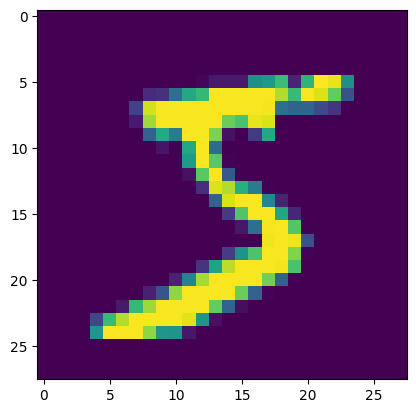

In [5]:
plt.imshow(X[0])

In [6]:
Y[0]

5

In [ ]:
forward()

In [17]:
def forward_and_train_cnn(
    list_X: Union[list[np.ndarray], np.ndarray], 
    Y: np.ndarray, 
    learning_rate: float, 
    epochs: int,
    list_X_predict: Union[list[np.ndarray], np.ndarray]):
    """
    
    """
    
    
    def reshape_list_X(list_X: Union[list[np.ndarray], np.ndarray]):
        N = len(list_X)
        list_P_0 = list_X
        
        if (type(list_X) == list and len(list_X[0].shape) == 3) or len(list_X.shape) == 4:
            pass
        elif type(list_X) == np.ndarray and len(list_X.shape) == 3:
            first_X = list_X[0]
            X_number_row = first_X.shape[0]
            X_number_col = first_X.shape[1]
            list_P_0 = list_X.reshape([N, X_number_row, X_number_col, 1])
        
        return list_P_0
    
    list_P_0 = reshape_list_X(list_X)
    
    # Init value for convolution layers
    K_11 = init_kernel((5, 5, 1)) # Kernel 11 
    K_12 = init_kernel((5, 5, 1)) # Kernel 12
    bk_11 = init_bias_kernel() # Bias kernel 11
    bk_12 = init_bias_kernel() # Bias kernel 12
    sk_1 = 1 # Stride kernel 1
    sp_1 = 2 # Stride pool 1
    size_pool_1 = (2, 2) # Size of pooling 1
    
    K_21 = init_kernel((3, 3, 2)) # Kernel 21
    K_22 = init_kernel((3, 3, 2)) # Kernel 22
    K_23 = init_kernel((3, 3, 2)) # Kernel 23 
    K_24 = init_kernel((3, 3, 2)) # Kernel 24
    bk_21 = init_bias_kernel() # Bias kernel 21
    bk_22 = init_bias_kernel() # Bias kernel 22
    bk_23 = init_bias_kernel() # Bias kernel 23
    bk_24 = init_bias_kernel() # Bias kernel 24
    sk_2 = 1 # Stride kernel 2
    sp_2 = 2 # Stride pool 2
    size_pool_2 = (2, 2) # Size of pooling 1
    
    Zk_1_size = [24, 24, 2]
    C_1_size = [24, 24, 2]
    P_1_size = [12, 12, 2]
    
    Zk_2_size = [10, 10, 4]
    C_2_size = [10, 10, 4]
    P_2_size = [5, 5, 4]
    
    # Init value for fully connected layers
    number_nn_layer_1 = 100
    W_1 = init_weights((np.prod(P_2_size), number_nn_layer_1))
    b_1 = init_bias((number_nn_layer_1, 1))
    
    number_nn_layer_2 = 100
    W_2 = init_weights((number_nn_layer_1, number_nn_layer_2))
    b_2 = init_bias((number_nn_layer_2, 1))
    
    number_nn_layer_3 = Y.shape[0] # Number of categories into which the data is classified.
    W_3 = init_weights((number_nn_layer_2, number_nn_layer_3))
    b_3 = init_bias((number_nn_layer_3, 1))
    
    def forward(mode: Literal["train", "predict"],

                list_P_0,
                
                K_11,
                K_12,
                bk_11,
                bk_12,
                sk_1,
                sp_1,
                size_pool_1,
                
                Zk_1_size,
                C_1_size,
                P_1_size,
                
                K_21,
                K_22,
                K_23,
                K_24,
                bk_21,
                bk_22,
                bk_23,
                bk_24,
                sk_2,
                sp_2,
                size_pool_2,

                Zk_2_size,
                C_2_size,
                P_2_size,
                
                W_1,
                b_1,
                
                W_2,
                b_2,
                
                W_3,
                b_3,
                
                Y=None):
        
        N = len(list_P_0)
        
        list_Zk_1 = np.zeros([N] + Zk_1_size)
        list_C_1 = np.zeros([N] + C_1_size)
        list_P_1 = np.zeros([N] + P_1_size)
        
        list_Zk_2 = np.zeros([N] + Zk_2_size)
        list_C_2 = np.zeros([N] + C_2_size)
        list_P_2 = np.zeros([N] + P_2_size)
        
        A_0 = np.zeros((np.prod(P_2_size), N))
        
        # Calculate for kernel layers and input A_0 for fully connected layres
        for i, each_point_data_p_0 in enumerate(list_P_0):        
            Zk_1 = convolution_multiple_kernel(each_point_data_p_0, (K_11, K_12), (bk_11, bk_12), sk_1)
            C_1 = ReLU(Zk_1)
            P_1 = pooling(C_1, size_pool_1, stride=sp_1)
            
            Zk_2 = convolution_multiple_kernel(P_1, (K_21, K_22, K_23, K_24), (bk_21, bk_22, bk_23, bk_24), sk_2)
            C_2 = Sigmoid(Zk_2)
            P_2 = pooling(C_2, size_pool_2, stride=sp_2)
            
            list_Zk_1[i] = Zk_1
            list_C_1[i] = C_1
            list_P_1[i] = P_1
            
            list_Zk_2[i] = Zk_2
            list_C_2[i] = C_2
            list_P_2[i] = P_2
            
            A_0[:, i] = P_2.flatten()
        
        # Calculate for fully connected layers
        Z_1 = W_1.T.dot(A_0) + b_1
        A_1 = ReLU(Z_1)
        
        Z_2 = W_2.T.dot(A_1) + b_2
        A_2 = ReLU(Z_2)
        
        Z_3 = W_3.T.dot(A_2) + b_3
        A_3 = softmax(Z_3) # This is prediction output
        
        # calculate loss value by cross entropy
        loss = 0
        if mode == "train":
            loss = calculate_cross_entropy_loss_without_softmax_value(Y, Z_3)
        
        return (
            list_Zk_1,
            list_C_1,
            list_P_1,
            
            list_Zk_2,
            list_C_2,
            list_P_2,

            A_0,
            
            Z_1,
            A_1,
                    
            Z_2,
            A_2,
            
            Z_3,
            A_3,
            
            loss
        )
    
    chunk_count = 0  
    for chunk_P_0, chunk_Y in split_chunk_X_Y(list_P_0, Y, 300):
        print(f"Chunk {chunk_count}")
        chunk_count += 1
        
        # Backpropagation 
        for i in range(epochs):
            (
            list_Zk_1,
            list_C_1,
            list_P_1,
            list_Zk_2,
            list_C_2,
            list_P_2,
            A_0,
            Z_1,
            A_1,
            Z_2,
            A_2,
            Z_3, 
            A_3,
            loss
            ) = forward(
                "train",
                
                chunk_P_0,
                
                K_11,
                K_12,
                bk_11,
                bk_12,
                sk_1,
                sp_1,
                size_pool_1,
                
                Zk_1_size,
                C_1_size,
                P_1_size,
                
                K_21,
                K_22,
                K_23,
                K_24,
                bk_21,
                bk_22,
                bk_23,
                bk_24,
                sk_2,
                sp_2,
                size_pool_2,
                
                Zk_2_size,
                C_2_size,
                P_2_size,
                
                W_1,
                b_1,
                W_2,
                b_2,
                W_3,
                b_3,
                
                chunk_Y
            )
            N = len(chunk_P_0)
            print(f"loop = {i}, loss = {loss}")
            
            # Backpropagation for fully connected layers
        
            E_3 = 1/N * (A_3 - chunk_Y)
            dL_dW_3 = A_2.dot(E_3.T)
            dL_db_3 = np.sum(E_3, axis=1, keepdims=True)
            
            E_2 = W_3.dot(E_3) * derivative_ReLU(Z_2)
            dL_dW_2 = A_1.dot(E_2.T)
            dL_db_2 = np.sum(E_2, axis=1, keepdims=True)
            
            E_1 = W_2.dot(E_2) * derivative_ReLU(Z_1)
            dL_dW_1 = A_0.dot(E_1.T)
            dL_db_1 = np.sum(E_1, axis=1, keepdims=True)
            
            # Backpropagation for kernel layers
            
            # Number of rows in dL_dP_2 = number of columns in dL_dA_0 = N
            # We loop through the columns of dL_dA_0 (respectively for each point data in X) and reshape it to size of P_2 and set that value in dL_dP_2
            dL_dA_0: np.ndarray = W_1.dot(E_1)
            list_dL_dP_2 = np.zeros([N] + P_2_size)
            
            for i in range(N):
                list_dL_dP_2[i] = dL_dA_0[:, i].reshape(P_2_size)

            list_dL_dC_2 = derivative_layer_before_max_pooling_for_multiple_point(list_C_2, list_P_2, list_dL_dP_2, size_pool_2, sp_2)
            list_dL_dZk_2 = list_dL_dC_2 * derivative_Sigmoid(list_Zk_2)
            
            dL_dK_21 = derivative_for_filter_multiple_point(list_P_1, list_dL_dZk_2[:, :, :, 0], K_21.shape, sk_2)
            dL_dK_22 = derivative_for_filter_multiple_point(list_P_1, list_dL_dZk_2[:, :, :, 1], K_22.shape, sk_2)
            dL_dK_23 = derivative_for_filter_multiple_point(list_P_1, list_dL_dZk_2[:, :, :, 2], K_23.shape, sk_2)
            dL_dK_24 = derivative_for_filter_multiple_point(list_P_1, list_dL_dZk_2[:, :, :, 3], K_24.shape, sk_2)
            
            dL_dbk_21 = derivative_for_bias_kernel_multiple_point(list_dL_dZk_2[:, :, :, 0])
            dL_dbk_22 = derivative_for_bias_kernel_multiple_point(list_dL_dZk_2[:, :, :, 1])
            dL_dbk_23 = derivative_for_bias_kernel_multiple_point(list_dL_dZk_2[:, :, :, 2])
            dL_dbk_24 = derivative_for_bias_kernel_multiple_point(list_dL_dZk_2[:, :, :, 3])
            
            list_dL_dP_1 = derivative_layer_input_convolution_multiple_point(list_P_1, [K_21, K_22, K_23, K_24], list_dL_dZk_2)
            list_dL_dC_1 = derivative_layer_before_max_pooling_for_multiple_point(list_C_1, list_P_1, list_dL_dP_1, size_pool_1, sp_1)
            list_dL_dZk_1 = list_dL_dC_1 * derivative_ReLU(list_Zk_1)
            
            dL_dK_11 = derivative_for_filter_multiple_point(chunk_P_0, list_dL_dZk_1[:, :, :, 0], K_11.shape, sk_1)
            dL_dK_12 = derivative_for_filter_multiple_point(chunk_P_0, list_dL_dZk_1[:, :, :, 1], K_12.shape, sk_1)
            
            dL_dbk_11 = derivative_for_bias_kernel_multiple_point(list_dL_dZk_1[:, :, :, 0])
            dL_dbk_12 = derivative_for_bias_kernel_multiple_point(list_dL_dZk_1[:, :, :, 1])
            
            W_3 = W_3 - learning_rate*dL_dW_3
            b_3 = b_3 - learning_rate*dL_db_3
            
            W_2 = W_2 - learning_rate*dL_dW_2
            b_2 = b_2 - learning_rate*dL_db_2
            
            W_1 = W_1 - learning_rate*dL_dW_1
            b_1 = b_1 - learning_rate*dL_db_1
            
            K_21 = K_21 - learning_rate*dL_dK_21
            K_22 = K_22 - learning_rate*dL_dK_22
            K_23 = K_23 - learning_rate*dL_dK_23
            K_24 = K_24 - learning_rate*dL_dK_24
            
            bk_21 = bk_21 - learning_rate*dL_dbk_21
            bk_22 = bk_22 - learning_rate*dL_dbk_22
            bk_23 = bk_23 - learning_rate*dL_dbk_23
            bk_24 = bk_24 - learning_rate*dL_dbk_24
            
            K_11 = K_11 - learning_rate*dL_dK_11
            K_12 = K_12 - learning_rate*dL_dK_12
            
            bk_11 = bk_11 - learning_rate*dL_dbk_11
            bk_12 = bk_12 - learning_rate*dL_dbk_12
    
    
    (
    list_Zk_1, 
    list_C_1, 
    
    list_P_1,
    list_Zk_2,
    
    list_C_2,
    list_P_2,
    
    A_0,
    
    Z_1,
    A_1,
    
    Z_2,
    A_2,
    
    Z_3,
    A_3,
    
    loss
    ) = forward(
            "predict",
            
            reshape_list_X(list_X_predict),
                
            K_11,
            K_12,
            bk_11,
            bk_12,
            sk_1,
            sp_1,
            size_pool_1,
            
            Zk_1_size,
            C_1_size,
            P_1_size,
            
            K_21,
            K_22,
            K_23,
            K_24,
            bk_21,
            bk_22,
            bk_23,
            bk_24,
            sk_2,
            sp_2,
            size_pool_2,
            
            Zk_2_size,
            C_2_size,
            P_2_size,
            
            W_1,
            b_1,
            W_2,
            b_2,
            W_3,
            b_3,
            
            None
        )
    return {
        "result": {
            "list_Zk_1": list_Zk_1, 
            "list_C_1": list_C_1, 
            
            "list_P_1": list_P_1,
            "list_Zk_2": list_Zk_2,
            
            "list_C_2": list_C_2,
            "list_P_2": list_P_2,
            
            "A_0": A_0,
            
            "Z_1": Z_1,
            "A_1": A_1,
            
            "Z_2": Z_2,
            "A_2": A_2,
            
            "Z_3": Z_3,
            "A_3": A_3,
            
            "loss": loss,
        },
        "params": {
            "K_11": K_11,
            "K_12": K_12,
            
            "bk_11": bk_11,
            "bk_12": bk_12,
            
            "K_21": K_21,
            "K_22": K_22,
            "K_23": K_23,
            "K_24": K_24,
            
            "bk_21": bk_21,
            "bk_22": bk_22,
            "bk_23": bk_23,
            "bk_24": bk_24,
            
            "W_1": W_1,
            "b_1": b_1,

            "W_2": W_2,
            "b_2": b_2,

            "W_3": W_3,
            "b_3": b_3,
        },
        "forward": forward,
        "reshape_list_X": reshape_list_X
    }

In [18]:
number_train_points = 500

In [20]:
output = forward_and_train_cnn(
    X[0:number_train_points], 
    one_hot(Y[0:number_train_points]), 
    0.1, 
    50, 
    X[number_train_points:number_train_points + 10])

Chunk 0


d:\code\selenium\data_analytics\try_cnn\utils_cnn.py:454: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp((-1) * X))


loop = 0, loss = 2.7530919627460246
loop = 1, loss = 2.4270650608317403
loop = 2, loss = 2.197300823592948
loop = 3, loss = 2.114882129196458
loop = 4, loss = 2.0514611624299177
loop = 5, loss = 2.004072745143233
loop = 6, loss = 1.938155910470811
loop = 7, loss = 1.9633803169560968
loop = 8, loss = 1.8942425568151757
loop = 9, loss = 1.8121742229163313
loop = 10, loss = 1.7650210696112967
loop = 11, loss = 1.7624938029796489
loop = 12, loss = 1.6826637502253312
loop = 13, loss = 1.6233217610027635
loop = 14, loss = 1.6225521074431675
loop = 15, loss = 1.59918234289562
loop = 16, loss = 1.5614402481943157
loop = 17, loss = 1.5597109654899393
loop = 18, loss = 1.5386697470972288
loop = 19, loss = 1.514711406683905
loop = 20, loss = 1.5408497923429276
loop = 21, loss = 1.5129638260218112
loop = 22, loss = 1.5601309557447762
loop = 23, loss = 1.4274231902987693
loop = 24, loss = 1.4159318769258162
loop = 25, loss = 1.2950558677920587
loop = 26, loss = 1.2715289031450827
loop = 27, loss = 

In [21]:
result = output["result"]
params = output["params"]

In [22]:
Y_predict = result["A_3"]
Z_3 = result["Z_3"]

In [23]:
Y_predict.shape

(10, 10)

In [24]:
Y_predict

array([[7.24576825e-04, 1.22005525e-04, 5.05434839e-03, 5.90422902e-03,
        9.59306985e-03, 5.81561487e-04, 3.07590644e-03, 2.86431551e-05,
        6.68908967e-03, 5.52462610e-03],
       [1.66436304e-03, 1.02895345e-02, 8.03333622e-02, 2.38547223e-01,
        4.27295287e-03, 4.74333805e-05, 1.29241372e-02, 9.72245426e-01,
        7.37641228e-01, 8.52752244e-04],
       [2.00100884e-01, 1.50690413e-03, 7.50808599e-02, 2.98561337e-02,
        5.75357934e-02, 1.13493023e-04, 6.22377764e-02, 7.13769388e-03,
        3.33040266e-02, 7.01835934e-03],
       [5.90206847e-04, 6.68508302e-03, 2.94828055e-01, 4.20035676e-03,
        3.71440810e-01, 4.60500923e-05, 6.74680291e-03, 3.95363321e-04,
        7.69577972e-04, 7.57409211e-03],
       [2.00241533e-03, 6.80069528e-02, 5.14100828e-02, 4.85092959e-02,
        1.20583848e-02, 3.75960296e-03, 1.26295782e-01, 2.24584363e-03,
        3.27716662e-02, 9.47473863e-02],
       [2.83067822e-04, 1.91282783e-02, 2.81228254e-01, 3.93045504e-02,
   

In [25]:
print(decode_one_hot(Y_predict, Y[0:number_train_points]))
print(Y[number_train_points:number_train_points + 10])

[7 9 3 8 8 7 6 1 1 9]
[3 9 5 8 5 7 6 1 1 3]


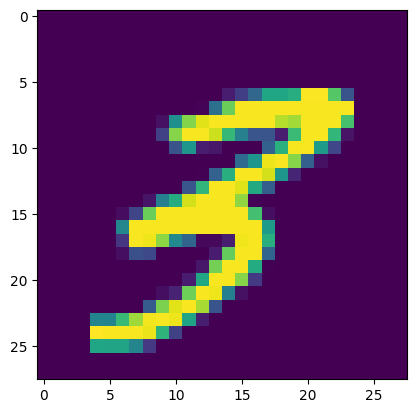

In [28]:
list_X_test = X[number_train_points:number_train_points + 10]
X_test_1 = list_X_test[-1]

plt.imshow(X_test_1)


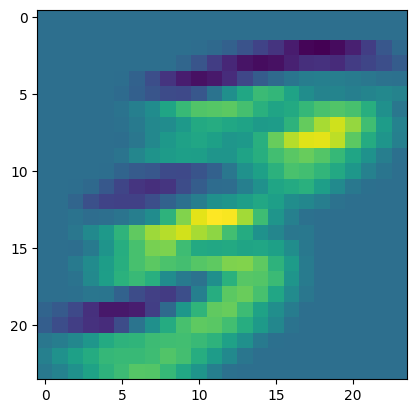

In [29]:
Zk_1_m1 = convolution(X_test_1, params["K_11"], bias=params["bk_11"])
plt.imshow(Zk_1_m1)

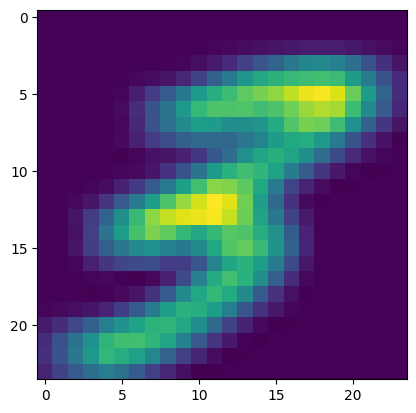

In [30]:
Zk_1_m2 = convolution(X_test_1, params["K_12"], bias=params["bk_12"])
plt.imshow(Zk_1_m2)

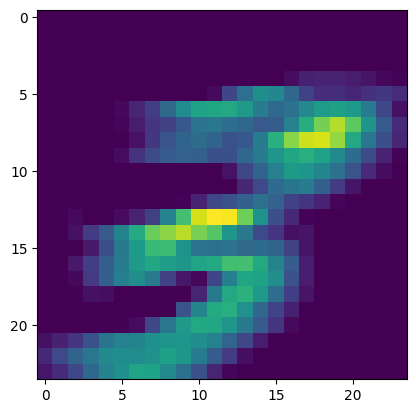

In [31]:
C_1_m1 = ReLU(Zk_1_m1)
plt.imshow(C_1_m1)

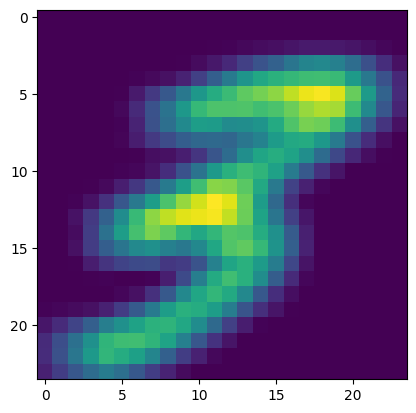

In [32]:
C_1_m2 = ReLU(Zk_1_m2)
plt.imshow(C_1_m2)

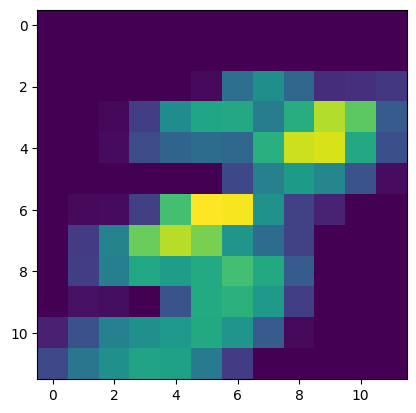

In [33]:
P_1_m1 = pooling(C_1_m1, (2, 2), stride=2)
plt.imshow(P_1_m1)

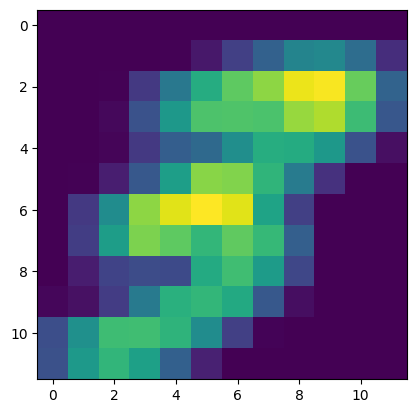

In [34]:
P_1_m2 = pooling(C_1_m2, (2, 2), stride=2)
plt.imshow(P_1_m2)

In [35]:
P_1 = np.zeros((12, 12, 2))
P_1[:,:,0] = P_1_m1
P_1[:,:,1] = P_1_m2

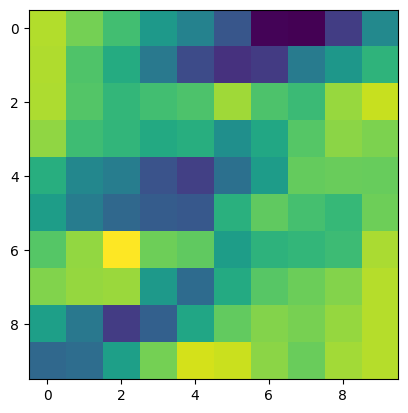

In [36]:
Zk_2_m1 = convolution(P_1, params["K_21"], bias=params["bk_21"])
plt.imshow(Zk_2_m1)

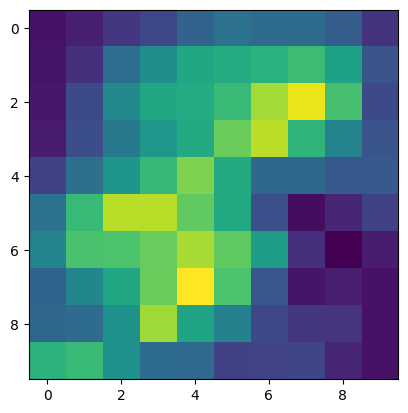

In [37]:
Zk_2_m2 = convolution(P_1, params["K_22"], bias=params["bk_22"])
plt.imshow(Zk_2_m2)

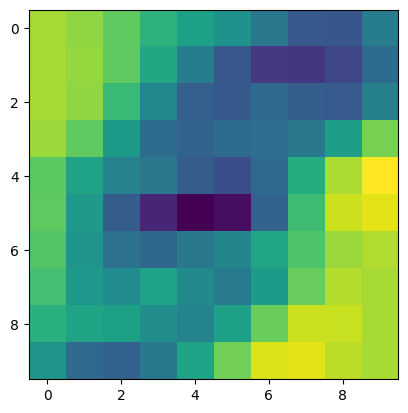

In [38]:
Zk_2_m3 = convolution(P_1, params["K_23"], bias=params["bk_23"])
plt.imshow(Zk_2_m3)

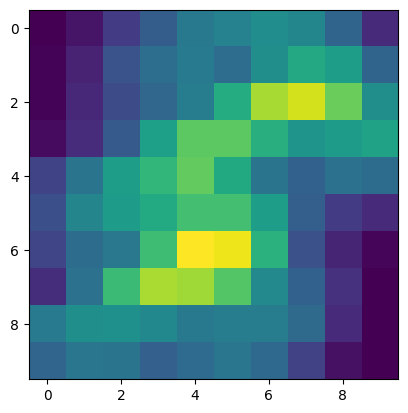

In [39]:
Zk_2_m4 = convolution(P_1, params["K_24"], bias=params["bk_24"])
plt.imshow(Zk_2_m4)

In [40]:
Zk_2 = np.zeros((10, 10, 4))
Zk_2[:,:,0] = Zk_2_m1
Zk_2[:,:,1] = Zk_2_m2
Zk_2[:,:,2] = Zk_2_m3
Zk_2[:,:,3] = Zk_2_m4

In [41]:
C_2 = Sigmoid(Zk_2)

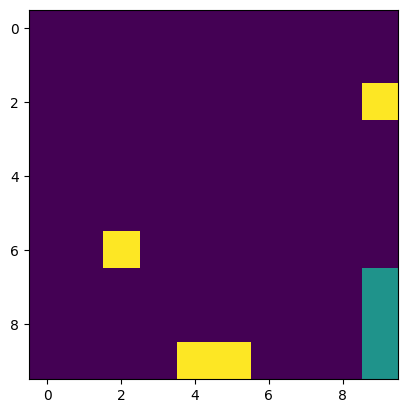

In [42]:
plt.imshow(C_2[:,:,0])


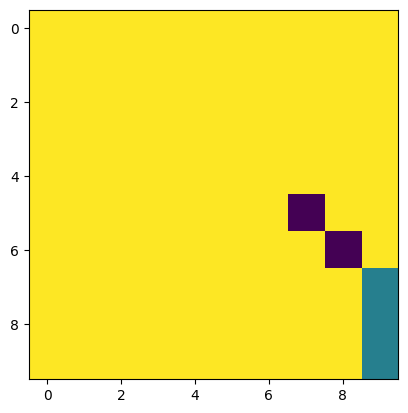

In [43]:
plt.imshow(C_2[:,:,1])


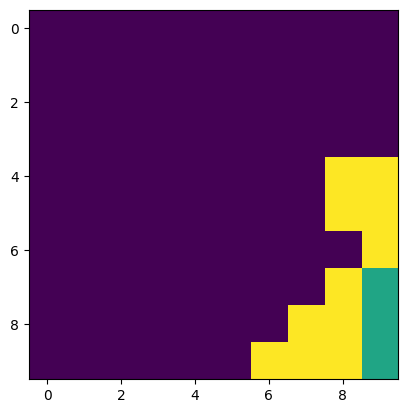

In [44]:
plt.imshow(C_2[:,:,2])


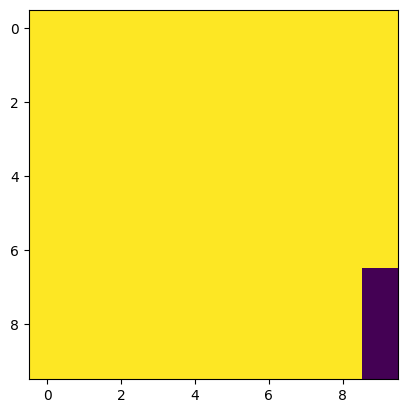

In [45]:
plt.imshow(C_2[:,:,3])

In [46]:
P_2 = pooling(C_2, (2, 2), stride=2)

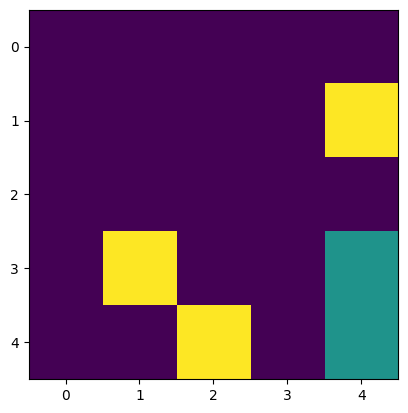

In [47]:
plt.imshow(P_2[:,:,0])


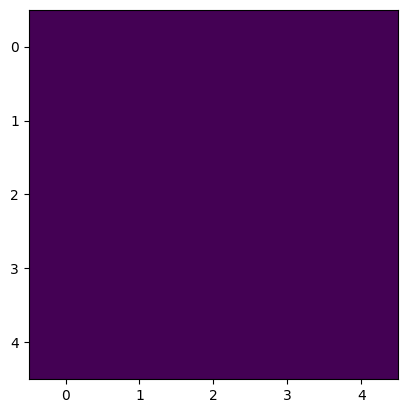

In [48]:
plt.imshow(P_2[:,:,1])


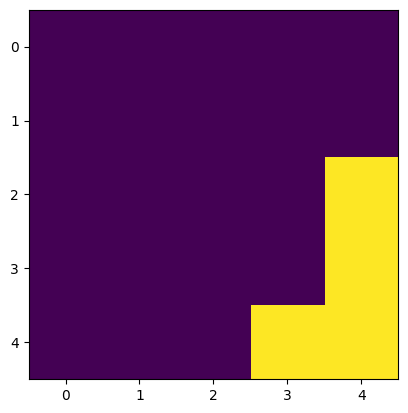

In [49]:
plt.imshow(P_2[:,:,2])


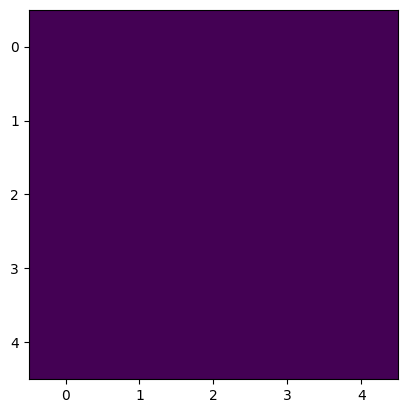

In [50]:
plt.imshow(P_2[:,:,3])